# **1. Instalaci√≥n de librerias**

In [117]:
# Librerias generales
# Pandas
import pandas as pd
pd.set_option('display.max_columns', 25) # N√∫mero m√°ximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # N√∫mero m√°ximo de filas a mostar
# Ranom seed
import numpy as np
np.random.seed(3301)

# Seaborn
import seaborn as sns

# Matplolib
%matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
import unicodedata
import re
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [118]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [119]:
!pip install langdetect
from langdetect import detect #Para identificar idiomas de textos

In [120]:
!pip install googletrans==4.0.0-rc1
from googletrans import Translator #Libreria para realizar traduccion

# **2. Carga de datos**

In [172]:
db_location='/content/tipo2_entrenamiento_estudiantes.csv'
db_pred_location='/content/particion_prueba_estudiantes.csv'
dataFrame=pd.read_csv(db_location, sep=',', encoding = "UTF-8")
df_pred=pd.read_csv(db_pred_location, sep=',', encoding = "UTF-8")
data=dataFrame

# **3. Entendimiento**

Se va a realizar un manejo b√°sico de lso datos para identificar diferentes estadisticas e informaci√≥n general acerca de las rese√±as

In [122]:
data.shape

(7875, 2)

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [124]:
data

Review  Class
0     Muy buena atenci√≥n y aclaraci√≥n de dudas por p...      5
1     Buen hotel si est√°n obligados a estar cerca de...      3
2     Es un lugar muy lindo para fotograf√≠as, visite...      5
3     Abusados con la factura de alimentos siempre s...      3
4     Tuvimos un par de personas en el grupo que rea...      3
...                                                 ...    ...
7870  Me parece buen sistema, agiliza el transporte,...      4
7871  Fue una escapada de un d√≠a desde el complejo, ...      4
7872  La Plaza de la Revoluci√≥n es un lugar emblem√°t...      3
7873  Es la segunda ocasi√≥n que me quedo en los cuar...      1
7874  Llegamos por casualidad a Los Mercaderes, un g...      5

[7875 rows x 2 columns]

In [125]:
def moda_palabras(review):
    palabras = review.split()
    moda = Counter(palabras).most_common(1)
    return moda[0][0] if moda else None

In [126]:
textos = data.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Moda'] = [moda_palabras(i) for i in textos['Review']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos

Review  Class  Conteo Moda  \
0     Muy buena atenci√≥n y aclaraci√≥n de dudas por p...      5     252   de   
1     Buen hotel si est√°n obligados a estar cerca de...      3     297   de   
2     Es un lugar muy lindo para fotograf√≠as, visite...      5     104   Es   
3     Abusados con la factura de alimentos siempre s...      3     422    y   
4     Tuvimos un par de personas en el grupo que rea...      3     419   el   
...                                                 ...    ...     ...  ...   
7870  Me parece buen sistema, agiliza el transporte,...      4     113   el   
7871  Fue una escapada de un d√≠a desde el complejo, ...      4     261   de   
7872  La Plaza de la Revoluci√≥n es un lugar emblem√°t...      3     777   de   
7873  Es la segunda ocasi√≥n que me quedo en los cuar...      1     651  que   
7874  Llegamos por casualidad a Los Mercaderes, un g...      5     252    a   

      Max  Min  
0      20    0  
1      13    1  
2      12    1  
3      14    1  
4      14    1  
...   ...  ...  
7870   11    2  
7871   12    2  
7872   14    1  
7873   12    0  
7874   11    1  

[7875 rows x 6 columns]

Se evidencia que la moda de las palabras son stopwords que no ofrecen ning√∫n tipo de informaci√≥n para el modelo. Por ello se van a eliminar en la preparaci√≥n de datos.

In [127]:
#identificar idiomas
textos['idioma']=[detect(x) for x in textos['Review']]

In [128]:
textos

Review  Class  Conteo Moda  \
0     Muy buena atenci√≥n y aclaraci√≥n de dudas por p...      5     252   de   
1     Buen hotel si est√°n obligados a estar cerca de...      3     297   de   
2     Es un lugar muy lindo para fotograf√≠as, visite...      5     104   Es   
3     Abusados con la factura de alimentos siempre s...      3     422    y   
4     Tuvimos un par de personas en el grupo que rea...      3     419   el   
...                                                 ...    ...     ...  ...   
7870  Me parece buen sistema, agiliza el transporte,...      4     113   el   
7871  Fue una escapada de un d√≠a desde el complejo, ...      4     261   de   
7872  La Plaza de la Revoluci√≥n es un lugar emblem√°t...      3     777   de   
7873  Es la segunda ocasi√≥n que me quedo en los cuar...      1     651  que   
7874  Llegamos por casualidad a Los Mercaderes, un g...      5     252    a   

      Max  Min idioma  
0      20    0     es  
1      13    1     es  
2      12    1     es  
3      14    1     es  
4      14    1     es  
...   ...  ...    ...  
7870   11    2     es  
7871   12    2     es  
7872   14    1     es  
7873   12    0     es  
7874   11    1     es  

[7875 rows x 7 columns]

Se utilizo la libreria langdetect con el fin de identificar el idioma en el cual se encuentra la rese√±a. Esto con el fin de identificar si hay que realizar algun tratamiento con respecto a la traducci√≥n de ciertas rese√±as.

In [129]:
idioma=textos[textos['idioma'] != 'es']
idioma

Review  Class  Conteo  \
296   Excelente! Servicio estuvo excelente. \nLa com...      5     112   
711   mas o menos estan mejor las de saltillo l√±dkjv...      2     116   
3749  First part of the tour was Rivera's actual hom...      2     351   
4490                                          esta rico      4       9   
6518  A few months after ciudad perdida we keep on t...      5     394   
6869  Cementerio Antiguo. Patrimonio Mundial. facil ...      5     102   
7455  This university is unique around the world. Th...      5     213   

            Moda  Max  Min idioma  
296   excelente.   12    2     pt  
711          mas   76    1     sq  
3749          of   10    2     en  
4490        esta    4    4     it  
6518           a   14    1     en  
6869  Cementerio   10    2     it  
7455          is   12    2     en

Se evidencia que las rese√±as se encuntran en otros idiomas diferentes al espa√±ol. Aunque los que se identifica diferente a ingles se evidencia que estan en espa√±ol.

In [130]:
col=['Class']
textos[col].describe()

Class
count  7875.000000
mean      3.502603
std       1.320435
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000

Se verifico la columna de class con el fin de mirar que todos los valores dados esten dentro del rango especificado. Como se evidencia en la tabla esto es verdadero.

# **4. Preparaci√≥n**

Para la preparaci√≥n de los datos se van a realizar 3 etapas:

1. Traducci√≥n
2. Tokenizaci√≥n
3. Normalizaci√≥n

##**4.1 Traducci√≥n**

Por medio de la libreria googletrans se va a realizar una traducci√≥n de las rese√±as que estan en ingles. Esto se debe a que las rese√±as que en el entendimiento capto en otro idioma (como italiano) realmente se encontraban en espa√±ol por lo que no es necesario realizar una traducci√≥n.

In [131]:
def traducir(row):
    review = row['Review']
    idioma = row['idioma']
    if idioma == 'en':
        translator = Translator()
        traduccion = translator.translate(review, src=idioma, dest='es')
        return traduccion.text
    else:
        return review

textos['Review'] = textos.apply(traducir, axis=1)

In [132]:
idioma=textos[textos['idioma'] != 'es']
idioma

Review  Class  Conteo  \
296   Excelente! Servicio estuvo excelente. \nLa com...      5     112   
711   mas o menos estan mejor las de saltillo l√±dkjv...      2     116   
3749  La primera parte de la gira fue el hogar real ...      2     351   
4490                                          esta rico      4       9   
6518  Unos meses despu√©s de Ciudad Perdida, seguimos...      5     394   
6869  Cementerio Antiguo. Patrimonio Mundial. facil ...      5     102   
7455  Esta universidad es √∫nica en todo el mundo.¬°La...      5     213   

            Moda  Max  Min idioma  
296   excelente.   12    2     pt  
711          mas   76    1     sq  
3749          of   10    2     en  
4490        esta    4    4     it  
6518           a   14    1     en  
6869  Cementerio   10    2     it  
7455          is   12    2     en

In [133]:
cols=['Review','Class']
data=textos[cols]

##**4.2 Tokenizaci√≥n**

En este punto se va a dividir los textos en palabras individuales por lo que cada token va a representar una palabra de la rese√±a. Al dividir el texto en tokens, se simplifica la tarea de limpieza y normalizaci√≥n, ya que se puede aplicar cada paso de preprocesamiento de manera individual a cada token

In [134]:
data['words'] = [nltk.word_tokenize(x) for x in data['Review']]

<ipython-input-134-e2126c2407d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['words'] = [nltk.word_tokenize(x) for x in data['Review']]


In [135]:
cols=['words','Class']
data=data[cols]
data

words  Class
0     [Muy, buena, atenci√≥n, y, aclaraci√≥n, de, duda...      5
1     [Buen, hotel, si, est√°n, obligados, a, estar, ...      3
2     [Es, un, lugar, muy, lindo, para, fotograf√≠as,...      5
3     [Abusados, con, la, factura, de, alimentos, si...      3
4     [Tuvimos, un, par, de, personas, en, el, grupo...      3
...                                                 ...    ...
7870  [Me, parece, buen, sistema, ,, agiliza, el, tr...      4
7871  [Fue, una, escapada, de, un, d√≠a, desde, el, c...      4
7872  [La, Plaza, de, la, Revoluci√≥n, es, un, lugar,...      3
7873  [Es, la, segunda, ocasi√≥n, que, me, quedo, en,...      1
7874  [Llegamos, por, casualidad, a, Los, Mercaderes...      5

[7875 rows x 2 columns]

##**4.3 Normalizaci√≥n**

Para este punto se va a realizar el siguiente tratamiento a cada uno de los tokens de las rese√±as:
1. Convertir el texto a minuscula.
2. eliminar caracteres no alfabeticos.
3. Eliminar espacios en blanco adicionales.
4. Eliminar stopwords
5. Lematizaci√≥n
6. Normalizaci√≥n n√∫meros

### **4.3.1 Convertir el texto a minuscula**

In [136]:
data['words'] = [[word.lower() for word in row] for row in data['words']]
data

words  Class
0     [muy, buena, atenci√≥n, y, aclaraci√≥n, de, duda...      5
1     [buen, hotel, si, est√°n, obligados, a, estar, ...      3
2     [es, un, lugar, muy, lindo, para, fotograf√≠as,...      5
3     [abusados, con, la, factura, de, alimentos, si...      3
4     [tuvimos, un, par, de, personas, en, el, grupo...      3
...                                                 ...    ...
7870  [me, parece, buen, sistema, ,, agiliza, el, tr...      4
7871  [fue, una, escapada, de, un, d√≠a, desde, el, c...      4
7872  [la, plaza, de, la, revoluci√≥n, es, un, lugar,...      3
7873  [es, la, segunda, ocasi√≥n, que, me, quedo, en,...      1
7874  [llegamos, por, casualidad, a, los, mercaderes...      5

[7875 rows x 2 columns]

### **4.3.2 Eliminar caracteres no alfabeticos**

In [137]:
data['words'] = data['words'].apply(lambda x: [re.sub(r'[^a-zA-Z√°√©√≠√≥√∫√º√±√Å√â√ç√ì√ö√ú√ë\s]', '', word) for word in x])
data

words  Class
0     [muy, buena, atenci√≥n, y, aclaraci√≥n, de, duda...      5
1     [buen, hotel, si, est√°n, obligados, a, estar, ...      3
2     [es, un, lugar, muy, lindo, para, fotograf√≠as,...      5
3     [abusados, con, la, factura, de, alimentos, si...      3
4     [tuvimos, un, par, de, personas, en, el, grupo...      3
...                                                 ...    ...
7870  [me, parece, buen, sistema, , agiliza, el, tra...      4
7871  [fue, una, escapada, de, un, d√≠a, desde, el, c...      4
7872  [la, plaza, de, la, revoluci√≥n, es, un, lugar,...      3
7873  [es, la, segunda, ocasi√≥n, que, me, quedo, en,...      1
7874  [llegamos, por, casualidad, a, los, mercaderes...      5

[7875 rows x 2 columns]

### **4.3.3 Eliminar espacios en blanco**

In [138]:
data['words'] = data['words'].apply(lambda x: [word for word in " ".join(x).split()])
data

words  Class
0     [muy, buena, atenci√≥n, y, aclaraci√≥n, de, duda...      5
1     [buen, hotel, si, est√°n, obligados, a, estar, ...      3
2     [es, un, lugar, muy, lindo, para, fotograf√≠as,...      5
3     [abusados, con, la, factura, de, alimentos, si...      3
4     [tuvimos, un, par, de, personas, en, el, grupo...      3
...                                                 ...    ...
7870  [me, parece, buen, sistema, agiliza, el, trans...      4
7871  [fue, una, escapada, de, un, d√≠a, desde, el, c...      4
7872  [la, plaza, de, la, revoluci√≥n, es, un, lugar,...      3
7873  [es, la, segunda, ocasi√≥n, que, me, quedo, en,...      1
7874  [llegamos, por, casualidad, a, los, mercaderes...      5

[7875 rows x 2 columns]

### **4.3.4 Eliminar stopwords**

In [139]:
stopwords_es = set(stopwords.words('spanish'))
data['words']=data['words'].apply(lambda x: [word for word in x if word.lower() not in stopwords_es])
data

words  Class
0     [buena, atenci√≥n, aclaraci√≥n, dudas, parte, se...      5
1     [buen, hotel, si, obligados, cerca, centro, co...      3
2     [lugar, lindo, fotograf√≠as, visiten, selina, m...      5
3     [abusados, factura, alimentos, siempre, echan,...      3
4     [par, personas, grupo, realmente, quer√≠amos, c...      3
...                                                 ...    ...
7870  [parece, buen, sistema, agiliza, transporte, c...      4
7871  [escapada, d√≠a, complejo, grupo, turistas, gu√≠...      4
7872  [plaza, revoluci√≥n, lugar, emblem√°tico, identi...      3
7873  [segunda, ocasi√≥n, quedo, cuartos, area, jard√≠...      1
7874  [llegamos, casualidad, mercaderes, grupo, gran...      5

[7875 rows x 2 columns]

### **4.3.5 Lematizaci√≥n**

In [140]:
stemmer = SnowballStemmer('spanish')
data['words'] = data['words'].apply(lambda words: [stemmer.stem(word) for word in words])
data

words  Class
0     [buen, atencion, aclar, dud, part, se√±orit, ve...      5
1     [buen, hotel, si, oblig, cerc, centr, convenci...      3
2     [lug, lind, fotograf, visit, selin, music, viv...      5
3     [abus, factur, aliment, siempr, echan, culp, v...      3
4     [par, person, grup, realment, quer, com, cabri...      3
...                                                 ...    ...
7870  [parec, buen, sistem, agiliz, transport, conec...      4
7871  [escap, dia, complej, grup, turist, gui, infor...      4
7872  [plaz, revolu, lug, emblemat, identif, haban, ...      3
7873  [segund, ocasion, qued, cuart, are, jardin, co...      1
7874  [lleg, casual, mercader, grup, grand, vari, fa...      5

[7875 rows x 2 columns]

### **4.3.6 Normalizaci√≥n n√∫meros**

In [141]:
def normalize_numbers(words):
    new_words = []
    for word in words:
        if re.match(r'^-?\d+(?:\.\d+)?$', word):
            new_words.append('NUM')
        else:
            new_words.append(word)
    return new_words

In [142]:
data['words'] = data['words'].apply(normalize_numbers)
data

words  Class
0     [buen, atencion, aclar, dud, part, se√±orit, ve...      5
1     [buen, hotel, si, oblig, cerc, centr, convenci...      3
2     [lug, lind, fotograf, visit, selin, music, viv...      5
3     [abus, factur, aliment, siempr, echan, culp, v...      3
4     [par, person, grup, realment, quer, com, cabri...      3
...                                                 ...    ...
7870  [parec, buen, sistem, agiliz, transport, conec...      4
7871  [escap, dia, complej, grup, turist, gui, infor...      4
7872  [plaz, revolu, lug, emblemat, identif, haban, ...      3
7873  [segund, ocasion, qued, cuart, are, jardin, co...      1
7874  [lleg, casual, mercader, grup, grand, vari, fa...      5

[7875 rows x 2 columns]

## **4.4 Bag of word**

El algoritmo bag of word convierte documentos de texto en vectores num√©ricos representando la frecuencia de ocurrencia de cada palabra en el documento. BoW es √∫til para la tarea de categorizaci√≥n de textos porque ignora el orden y la estructura gramatical del texto, centr√°ndose √∫nicamente en la presencia o ausencia de palabras clave. Esto permite una representaci√≥n eficiente de los documentos y simplifica la tarea de clasificaci√≥n al convertirla en un problema de asignaci√≥n de vectores a categor√≠as. Aunque BoW pierde informaci√≥n sem√°ntica y contextual, su simplicidad y eficacia lo hacen ampliamente utilizado en la clasificaci√≥n de texto.

In [143]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([' '.join(words) for words in data['words']])
y = data['Class']

## **4.5 Entrenamiento y test**

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **5. Implementaci√≥n de modelos**

## **5.1 Support vector machine (SVM)**

Su objetivo es encontrar un hiperplano en un espacio de caracter√≠sticas que maximice el margen entre las clases de datos, donde el margen es la distancia entre el hiperplano y los puntos de datos m√°s cercanos de cada clase, conocidos como vectores de soporte. SVM funciona encontrando el hiperplano √≥ptimo que separa las clases de datos utilizando una funci√≥n de p√©rdida, generalmente la p√©rdida de bisagra, que penaliza las clasificaciones incorrectas.

In [145]:
svm=SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [146]:
y_pred = svm.predict(X_test)

In [147]:
cm = confusion_matrix(y_test, y_pred)

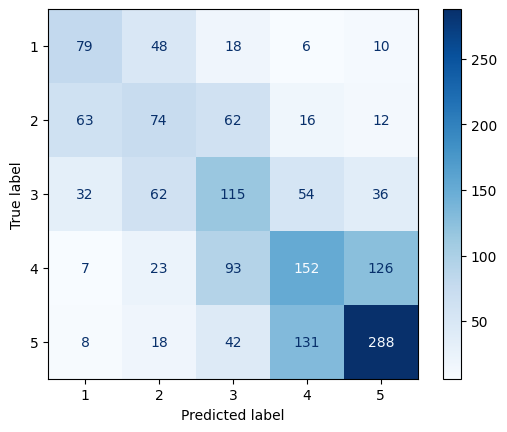

In [148]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [149]:
report_svm = classification_report(y_test, y_pred)
print("Test Report for SVM\n", report_svm)

Test Report for SVM
               precision    recall  f1-score   support

           1       0.42      0.49      0.45       161
           2       0.33      0.33      0.33       227
           3       0.35      0.38      0.37       299
           4       0.42      0.38      0.40       401
           5       0.61      0.59      0.60       487

    accuracy                           0.45      1575
   macro avg       0.43      0.43      0.43      1575
weighted avg       0.45      0.45      0.45      1575



Palabras seleccionadas para representar las rese√±as

In [150]:
coeficientes = svm.coef_.toarray()[0]

In [151]:
vocabulario = vectorizer.get_feature_names_out()
coeficientes_palabras = pd.DataFrame({'Palabra': vocabulario, 'Coeficiente': coeficientes})

In [152]:
palabras_importancia = coeficientes_palabras.sort_values(by='Coeficiente', ascending=False)

In [153]:
palabras_importancia.head(10)

Palabra  Coeficiente
12449        tibi     0.772680
3375         cuch     0.747528
13217  vidaademas     0.738099
5411        favor     0.727310
80           acab     0.693633
6566          ido     0.688011
9301       paisaj     0.682950
1023         asco     0.657932
2131      capacit     0.629000
11867     sombrer     0.628034

In [154]:
def encontrar_palabras_originales(raiz, palabras):
    palabras_originales = []
    for palabra in palabras:
        if raiz in palabra:
            palabras_originales.append(palabra)
    return palabras_originales

palabras_originales_por_raiz = {}
df_palabras=palabras_importancia.head(10)
for index, row in df_palabras.iterrows():
    raiz = row['Palabra']
    palabras_originales_por_raiz[raiz] = encontrar_palabras_originales(raiz, textos['Review'])

# Imprimir resultados
for raiz, palabras_originales in palabras_originales_por_raiz.items():
    print(f"Palabras originales para la ra√≠z '{raiz}': {palabras_originales}")

Palabras originales para la ra√≠z 'tibi': ['La presentaci√≥n de alimentos es nula. Tazones de salsa manchados. Platos manchados por la parte de abajo con lo cual el mantel queda sucio. Los tazones de consone manchados de todo el borde. Tardan en servir alimentos. El chilpachole estaba tibio y no caliente.', 'Acud√≠ con mi familia el fin de semana anterior a las elecciones en M√©xico. El precio es muy bueno en el todo incluido, la alberca del hotel es amplia y el agua es tibia, los cuartos tipo B son peque√±os, no tienes acceso a las bebidas del frigobar, la comida a la carta es recomendable en el restaurante italiano y el menu mexicano, s√≥lo que no toco mala experiencia con el mesero Jos√© en el italiano y la Sra que prepara los omelettes en el bufete por la ma√±ana, adem√°s la Sra de recepcion Micaela que creo era la supervisora de recepcion, con muy mala actitud para atendernos al extendernos una noche...Cabe resaltar la buena atencion del mesero Alex en la alberca y en recepcion Di

## **5.2 Regresi√≥n log√≠stica**

In [155]:
lr= LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [156]:
y_pred = lr.predict(X_test)

In [157]:
cm = confusion_matrix(y_test, y_pred)

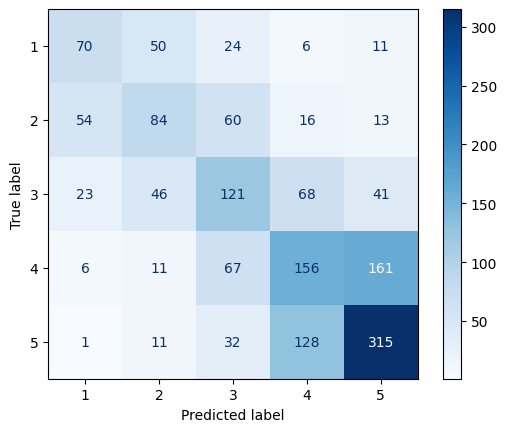

In [158]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [159]:
report_lr = classification_report(y_test, y_pred)
print("Test Report for Logistic Regression\n", report_lr)

Test Report for Logistic Regression
               precision    recall  f1-score   support

           1       0.45      0.43      0.44       161
           2       0.42      0.37      0.39       227
           3       0.40      0.40      0.40       299
           4       0.42      0.39      0.40       401
           5       0.58      0.65      0.61       487

    accuracy                           0.47      1575
   macro avg       0.45      0.45      0.45      1575
weighted avg       0.47      0.47      0.47      1575



In [160]:
coeficientes = lr.coef_[0]
palabras = vectorizer.get_feature_names_out()
palabra_coeficiente = dict(zip(palabras, coeficientes))
palabra_coeficiente_ordenado = sorted(palabra_coeficiente.items(), key=lambda x: abs(x[1]), reverse=True)
for palabra, coeficiente in palabra_coeficiente_ordenado[:10]:
    print(f"Palabra: {palabra}, Coeficiente: {coeficiente}")

Palabra: pesim, Coeficiente: 1.897743582355668
Palabra: horribl, Coeficiente: 1.6170762636286111
Palabra: peor, Coeficiente: 1.4736616184995641
Palabra: impresion, Coeficiente: -1.2003533547828307
Palabra: histori, Coeficiente: -1.1295141258054815
Palabra: desastr, Coeficiente: 1.1097837410984326
Palabra: enga√±, Coeficiente: 1.1055339837566462
Palabra: lament, Coeficiente: 1.1030818933662014
Palabra: excelent, Coeficiente: -1.0903750926015852
Palabra: rot, Coeficiente: 1.082175571314105


Lo que representa el coeficiente es cuando impacto tiene una palabra en la probabilidad que una rese√±a sea clasificada a cierta clase.

Las palabras que tienen coeficientes positivos sugieren que si estas palabras est√°n presentes en una rese√±a, el modelo es m√°s propenso a clasificarla como una rese√±a con una calificaci√≥n baja o negativa.

Por otro lado, las palabras que tienen coeficientes negativos significativos sugieren que si estas palabras est√°n presentes en una rese√±a, el modelo es menos propenso a clasificarla como una rese√±a con una calificaci√≥n baja o negativa, y podr√≠a indicar rese√±as con calificaciones m√°s altas.

## **5.3 Naive Bayes**

Naive Bayes es un algoritmo de aprendizaje supervisado basado en el teorema de Bayes. Se utiliza principalmente para la clasificaci√≥n de datos. Su "naive" (ingenuo) viene de la suposici√≥n de independencia condicional entre las caracter√≠sticas, lo que significa que asume que todas las caracter√≠sticas son independientes entre s√≠ dado el valor de la clase.

El algoritmo calcula la probabilidad de que una instancia pertenezca a una determinada clase bas√°ndose en la probabilidad condicional de las caracter√≠sticas dadas las clases. Luego, clasifica la instancia en la clase con la probabilidad m√°s alta.

Es simple, eficiente y funciona bien en conjuntos de datos con muchas caracter√≠sticas, como el an√°lisis de texto. Es especialmente √∫til cuando se tienen datos de alta dimensionalidad como el bag of words generado a partir de rese√±as tur√≠sticas.

In [161]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [162]:
y_pred_nb = nb_classifier.predict(X_test)

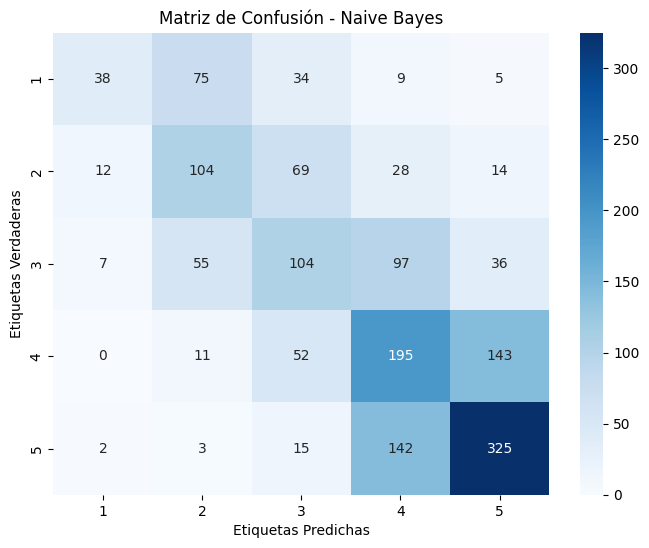

In [163]:
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusi√≥n - Naive Bayes")
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Verdaderas")
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5])
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=[1, 2, 3, 4, 5])
plt.show()

In [164]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy_nb)
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.48634920634920636
              precision    recall  f1-score   support

           1       0.64      0.24      0.35       161
           2       0.42      0.46      0.44       227
           3       0.38      0.35      0.36       299
           4       0.41      0.49      0.45       401
           5       0.62      0.67      0.64       487

    accuracy                           0.49      1575
   macro avg       0.50      0.44      0.45      1575
weighted avg       0.50      0.49      0.48      1575



In [165]:
vocabulario = vectorizer.vocabulary_
palabras_ordenadas = sorted(vocabulario, key=lambda palabra: vocabulario[palabra])
print("Palabras utilizadas por el modelo para la clasificaci√≥n:")
print(palabras_ordenadas)

Palabras utilizadas por el modelo para la clasificaci√≥n:
['aa', 'ab', 'abaceri', 'abad', 'abaj', 'abajomas', 'abajotambien', 'abalanz', 'abander', 'abandon', 'abarc', 'abarrot', 'abast', 'abastec', 'abedul', 'abej', 'abertur', 'abiert', 'abierton', 'abigail', 'abismal', 'abit', 'abofete', 'aboleng', 'abon', 'abond', 'abord', 'aborigen', 'abort', 'aboved', 'abra', 'abrac', 'abraham', 'abran', 'abras', 'abrasador', 'abraz', 'abrazogregor', 'abre', 'abren', 'abres', 'abrevader', 'abri', 'abriend', 'abriendol', 'abrier', 'abrieron', 'abries', 'abrig', 'abril', 'abrir', 'abrirl', 'abrirn', 'abrirs', 'abro', 'abrogat', 'abrum', 'abs', 'absid', 'absolut', 'absolutamemt', 'absolutomas', 'absorb', 'absten', 'abstract', 'absurd', 'abuch', 'abuel', 'abund', 'abundantehabi', 'abur', 'aburr', 'aburridoel', 'aburridor', 'aburrir', 'aburriri', 'aburrirt', 'abus', 'ac', 'aca', 'acab', 'acabari', 'academ', 'academi', 'acalor', 'acamp', 'acantil', 'acapulc', 'acarici', 'acarr', 'acarre', 'acas', 'acced

In [166]:
log_probabilidades = nb_classifier.feature_log_prob_

vocabulario = vectorizer.get_feature_names_out()

palabras_log_probabilidad = [(palabra, log_probabilidad) for palabra, log_probabilidad in zip(vocabulario, log_probabilidades[1])]

palabras_log_probabilidad_ordenadas = sorted(palabras_log_probabilidad, key=lambda x: x[1], reverse=True)

print("Palabras m√°s importantes y sus log probabilidades:")
for palabra, log_probabilidad in palabras_log_probabilidad_ordenadas[:10]:
    print(f"Palabra: {palabra}, Log Probabilidad: {log_probabilidad}")


Palabras m√°s importantes y sus log probabilidades:
Palabra: hotel, Log Probabilidad: -4.265560502603546
Palabra: habit, Log Probabilidad: -4.469807420026466
Palabra: com, Log Probabilidad: -4.863032473240129
Palabra: buen, Log Probabilidad: -4.984471820099623
Palabra: mal, Log Probabilidad: -5.032300907789504
Palabra: servici, Log Probabilidad: -5.079507312359301
Palabra: si, Log Probabilidad: -5.082533033275838
Palabra: sol, Log Probabilidad: -5.215198999623931
Palabra: lug, Log Probabilidad: -5.222143471976742
Palabra: lleg, Log Probabilidad: -5.392687961579677


En un clasificador Naive Bayes multinomial, las log probabilidades representan el logaritmo de la probabilidad de observar una palabra dada una clase espec√≠fica. Aunque las log probabilidades pueden ser negativas, esto simplemente indica que la probabilidad de la palabra dada esa clase es menor que 1. Las palabras con log probabilidades m√°s negativas son m√°s importantes para la clasificaci√≥n de la clase, mientras que las menos negativas o positivas tienen menos influencia pero a√∫n contribuyen al proceso de clasificaci√≥n. Estas log probabilidades son √∫tiles para identificar las palabras m√°s relevantes en la clasificaci√≥n y comprender c√≥mo el modelo toma decisiones.

# **6. Modelo seleccionado**

Seleccionamos el modelo de regresi√≥n log√≠stica dado que es el que tiene mejores m√©tricas.Procedemos a automatizar la aplicaci√≥n del modelo con un pipeline.

In [167]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            # Tokenizaci√≥n
            tokens = word_tokenize(text)
            # Convertir a min√∫sculas, eliminar caracteres no alfab√©ticos, eliminar espacios en blanco y stopwords
            clean_tokens = [self.lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in self.stop_words]
            # Normalizaci√≥n de n√∫meros
            clean_text = ' '.join(clean_tokens)
            preprocessed_texts.append(clean_text)
        return preprocessed_texts

pipeline = Pipeline([
    ('preprocesador', TextPreprocessor()),
    ('vectorizador', CountVectorizer()),  # Convertir texto en vectores de palabras
    ('regresion_logistica', LogisticRegression())  # Modelo de regresi√≥n log√≠stica
])

In [169]:
X_train, X_test, y_train, y_test = train_test_split(dataFrame['Review'], dataFrame['Class'], test_size=0.2, random_state=42)

In [170]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocesador', TextPreprocessor()),
                ('vectorizador', CountVectorizer()),
                ('regresion_logistica', LogisticRegression())])

# **7. Predicci√≥n de datos nuevos**

In [173]:
predicciones = pipeline.predict(df_pred['Review'])

In [174]:
df_pred['Class'] = predicciones

In [175]:
df_pred.to_csv('datos_clasificados.csv', index=False)
